# Make Plots

## Packages

In [6]:
## Packages
import pyswat as ps 
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt 
import contextily as ctx
import numpy as np 
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import datetime
import string

## Read Data Files

In [2]:
os.chdir('/scratch/smj5vup/omoScenarios/BestPolicyEachObjCC/MakeFigures')

In [3]:
omo = gpd.read_file('shapefile/subs1.shp')
omo_df = pd.read_csv('data/omo.csv')
for col in omo_df.columns[22:]:
    omo[col] = omo_df[col]
omo.to_crs(epsg=3857, inplace=True)

riv = gpd.read_file('shapefile/riv1.shp')
riv_df = pd.read_csv('data/riv.csv')
for col in riv_df.columns[19:]:
    riv[col] = riv_df[col]
riv.to_crs(epsg=3857, inplace=True)

res =  gpd.read_file('shapefile/monitoring_points1.shp')
res.to_crs(epsg=3857, inplace=True)
res = res[(res.POINTID == 10) | (res.POINTID == 13) | (res.POINTID == 17)]
res.reset_index(inplace=True)
res_df = pd.read_csv('data/res.csv')
for col in res_df.columns[16:]:
    res[col] = res_df[col]

In [4]:
# read reservoir timeseries
df_gib = pd.read_csv('data/giii.csv', parse_dates=True, index_col = 0)
df_koy = pd.read_csv('data/koysha.csv', parse_dates=True, index_col = 0)


# find wet day and dry day
fpath_uc = '../../Historical/Timeseries/Uncontrolled'
UC = pd.read_csv(os.path.join(fpath_uc,'Historical_00_Flow.csv'), parse_dates=True, index_col = 'date')
max_day = UC[UC.flow == UC.flow.max()].index[0]
min_day = UC[(UC.flow == UC[UC.year > 2000].flow.min()) & (UC.year > 2000)].index[0]

# normalize volumes 
mx_g =1470000.0* 10**4
mx_k = 570000.0* 10**4  
mn_g = 292120.0* 10**4
mn_k = 76000.0* 10**4

for col in df_gib.columns:
    df_gib[col] = (df_gib[col] - mn_g) / (mx_g - mn_g) * 100
    df_koy[col] = (df_koy[col] - mn_k) / (mx_k - mn_k) * 100


In [5]:
Objectives = ['Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton'] 

/home/smj5vup/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-22-1da8d9e02ab6>:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


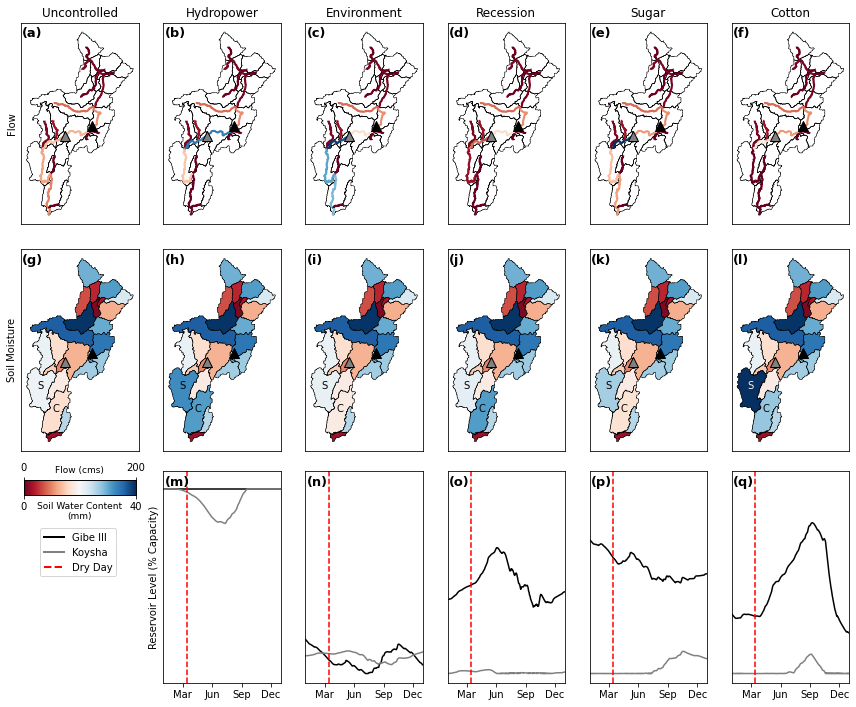

In [22]:
fig, ax = plt.subplots(3,6)
fig.set_size_inches(12, 10)

o = riv.plot(column="huc_FLOW_OUTcms_dry",
                ax=ax[0,0],
                cmap = "RdBu",
                vmin = 0,
                vmax = 200,
                edgecolor="k", 
                lw = 2)

o = omo.plot(ax=ax[0,0],
             facecolor="none",
             edgecolor="k", 
             lw = 0.5)

o = omo.plot(column="huc_SWmm_dry",
                ax=ax[1,0],
                cmap = "RdBu",
                vmin = 0,
                vmax = 40,
                edgecolor="k", 
                lw = 0.5)

maxes = [200, 40]

# dry year 
df_koy_mn = df_koy[df_koy.index.year == min_day.year]
df_gib_mn = df_gib[df_gib.index.year == min_day.year]
df_koy_mn.reset_index(inplace=True)
df_gib_mn.reset_index(inplace=True)


for i in range(2):
    for j in range(6):
        r = res[res.index == 1].plot(ax=ax[i,j],
                                     zorder=5,
                                     color='gray',
                                     marker="^",
                                     edgecolor='k',
                                     markersize = 100)
        r = res[res.index == 2].plot(ax=ax[i,j],
                                     zorder=5,
                                     color= "black",
                                     marker = "^",
                                     edgecolor='k',
                                     markersize = 100)

for i in range(3):
    
    for j in range(1,6):
        
        if i == 0:
            o = riv.plot(column="%s_FLOW_OUTcms_%s" % (Objectives[j-1], 'dry'),
                    ax=ax[i,j],
                    vmin = 0,
                    vmax = maxes[i],
                    cmap = "RdBu",
                    edgecolor="k", 
                    lw = 2)
            o = omo.plot(ax=ax[i,j],
                 facecolor="none",
                 edgecolor="k", 
                 lw = 0.5)
        elif i == 2:
            df_koy_mn[Objectives[j-1]].plot(ax=ax[i,j],
                                            color = 'black')
            df_gib_mn[Objectives[j-1]].plot(ax=ax[i,j], color = 'gray')
            ax[i,j].axvline(min_day.timetuple().tm_yday, color = 'red', linestyle = 'dashed')
            ax[i,j].set_ylim(-5,110)

        else:
            o = omo.plot(column="%s_SWmm_%s" % (Objectives[j-1], 'dry'),
                ax=ax[i,j],
                vmin = 0,
                vmax = maxes[i],
                cmap = "RdBu",
                edgecolor="k", 
                lw = 0.5)
            
sug_cot = omo[(omo.Subbasin == 24) | (omo.Subbasin == 25)]
sug_cot['labels'] = ['S', 'C']
            
for _, a in enumerate(fig.axes):        
    a.set_xticks([])
    a.set_yticks([])
    if _ - 6 < 0:
        a.set_title(['Uncontrolled', 'Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton'][_])
    if _ == 0:
        a.set_ylabel("Flow")
    elif _ == 6:
        a.set_ylabel("Soil Moisture")
    elif _ == 12:  
        for key, spine in a.spines.items():
            spine.set_visible(False)
    elif _ == 13:
        a.set_ylabel("Reservoir Level (% Capacity)")
    if _ - 12 > 0:
        a.set_xticks([60,152,244,335])
        a.set_xticklabels(['Mar','Jun','Sep','Dec'],fontsize=10)
        a.set_xlim(0,365)
    if _ < 12:
        a.text(0.01, 0.93, "("+ string.ascii_lowercase[_] + ")", transform=a.transAxes, size=13, weight='bold')
    elif _ > 12:
        a.text(0.01, 0.93, "(" + string.ascii_lowercase[_-1] + ")", transform=a.transAxes, size=13, weight='bold')
    if (_ < 12) & (_ >= 6):
        sug_cot.apply(lambda x: a.annotate(text=x['labels'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    if _ == 11:
        sug_cot[sug_cot.Subbasin==24].apply(lambda x: a.annotate(text=x['labels'], xy=x.geometry.centroid.coords[0], ha='center', color='white'), axis=1)




fig.delaxes(ax[2,0])

sm = plt.cm.ScalarMappable(cmap='RdBu')
sm.set_array([0,1])
cbar_ax = fig.add_axes([0.03, 0.3, 0.13, 0.02])
cbar = fig.colorbar(sm, ax=ax, cax = cbar_ax, orientation='horizontal', ticks=np.arange(0.0,2,1))
cbar.ax.set_xticklabels([0,40],fontsize = 10)
cbar.ax.set_xlabel("Soil Water Content\n(mm)", fontsize = 9)
cbar.ax.get_xaxis().labelpad = -10

ax1 = cbar.ax
ax2 = ax1.twiny()
ax2.xaxis.set_ticks_position('top') # set the position of the first axis to right
ax2.xaxis.set_label_position('top') # set the position of the fitst axis to right
# ax2.xaxis.set_ticks_position('top')
ax2.set_xticks(np.arange(0.0,2,1))
ax2.set_xticklabels([0,200],fontsize=10)
ax2.set_xlabel('Flow (cms)', fontsize=9)
ax2.get_xaxis().labelpad = -10



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='gray', lw=2),
                Line2D([0], [0], color='red', lw = 2, linestyle='dashed')]
leg_ax = fig.add_axes([0.013, 0.23, 0.13, 0.03])
leg_ax.legend(custom_lines, ['Gibe III', 'Koysha', 'Dry Day'], ncol=1)
for key, spine in leg_ax.spines.items():
    spine.set_visible(False)
leg_ax.set_xticks([])
leg_ax.set_yticks([])
        
plt.tight_layout()
plt.savefig('Figures/08_Dry.png')

<ipython-input-25-24a0187b876c>:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


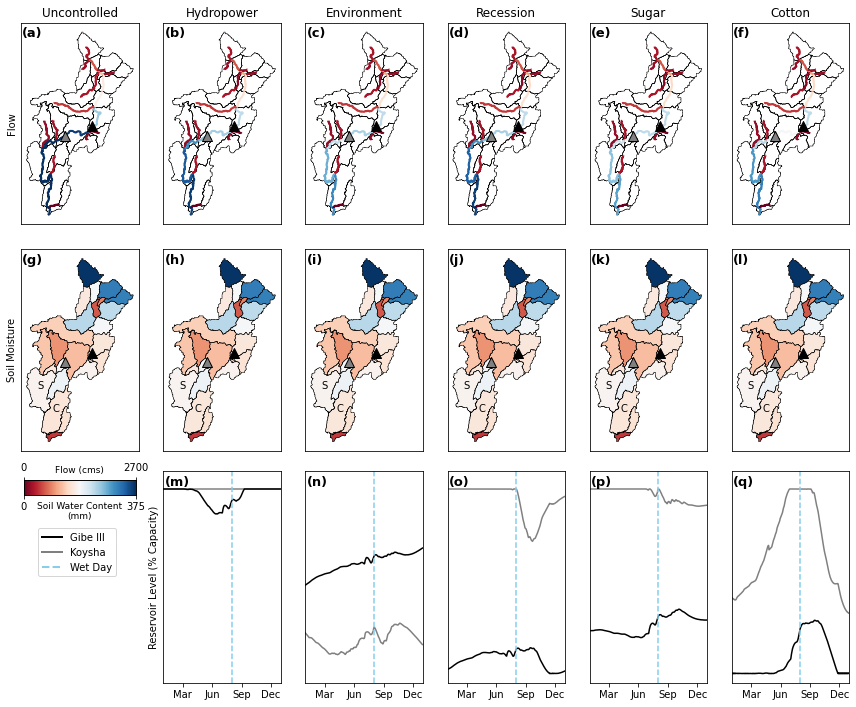

In [25]:
fig, ax = plt.subplots(3,6)
fig.set_size_inches(12, 10)
o = riv.plot(column="huc_FLOW_OUTcms_wet",
                ax=ax[0,0],
                cmap = "RdBu",
                vmin = 0,
                vmax = 2700,
                edgecolor="k", 
                lw = 2)
o = omo.plot(ax=ax[0,0],
             facecolor="none",
             edgecolor="k", 
             lw = 0.5)

o = omo.plot(column="huc_SWmm_wet",
                ax=ax[1,0],
                cmap = "RdBu",
                vmin = 0,
                vmax = 375,
                edgecolor="k", 
                lw = 0.5)

maxes = [2700, 375]


# dry year 
df_koy_mx = df_koy[df_koy.index.year == max_day.year]
df_gib_mx = df_gib[df_gib.index.year == max_day.year]
df_koy_mx.reset_index(inplace=True)
df_gib_mx.reset_index(inplace=True)


for i in range(2):
    for j in range(6):
        r = res[res.index == 1].plot(ax=ax[i,j],
                                     zorder=5,
                                     color='gray',
                                     marker="^",
                                     edgecolor='k',
                                     markersize = 100)
        r = res[res.index == 2].plot(ax=ax[i,j],
                                     zorder=5,
                                     color= "black",
                                     marker = "^",
                                     edgecolor='k',
                                     markersize = 100)
        
        
        
        
for i in range(3):
    
    for j in range(1,6):
        
        if i == 0:
            o = riv.plot(column="%s_FLOW_OUTcms_%s" % (Objectives[j-1], 'wet'),
                    ax=ax[i,j],
                    vmin = 0,
                    vmax = maxes[i],
                    cmap = "RdBu",
                    edgecolor="k", 
                    lw = 2)
            o = omo.plot(ax=ax[i,j],
                 facecolor="none",
                 edgecolor="k", 
                 lw = 0.5)
        elif i == 2:
            df_koy_mx[Objectives[j-1]].plot(ax=ax[i,j],
                                            color = 'gray')
            df_gib_mx[Objectives[j-1]].plot(ax=ax[i,j], color = 'black')
            ax[i,j].axvline(max_day.timetuple().tm_yday, color = 'skyblue', linestyle = 'dashed')
            ax[i,j].set_ylim(-5,110)


        else:
            o = omo.plot(column="%s_SWmm_%s" % (Objectives[j-1], 'wet'),
                ax=ax[i,j],
                vmin = 0,
                vmax = maxes[i],
                cmap = "RdBu",
                edgecolor="k", 
                lw = 0.5)
            
            
            
for _, a in enumerate(fig.axes):        
    a.set_xticks([])
    a.set_yticks([])
    if _ - 6 < 0:
        a.set_title(['Uncontrolled', 'Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton'][_])
    if _ == 0:
        a.set_ylabel("Flow")
    elif _ == 6:
        a.set_ylabel("Soil Moisture")
    elif _ == 12:  
        for key, spine in a.spines.items():
            spine.set_visible(False)
    elif _ == 13:
        a.set_ylabel("Reservoir Level (% Capacity)")
    if _ - 12 > 0:
        a.set_xticks([60,152,244,335])
        a.set_xticklabels(['Mar','Jun','Sep','Dec'],fontsize=10)
        a.set_xlim(0,365)
    if _ < 12:
        a.text(0.01, 0.93, "("+ string.ascii_lowercase[_] + ")", transform=a.transAxes, size=13, weight='bold')
    elif _ > 12:
        a.text(0.01, 0.93, "(" + string.ascii_lowercase[_-1] + ")", transform=a.transAxes, size=13, weight='bold')
    if (_ < 12) & (_ >= 6):
        sug_cot.apply(lambda x: a.annotate(text=x['labels'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
        
        
fig.delaxes(ax[2,0])

sm = plt.cm.ScalarMappable(cmap='RdBu')
sm.set_array([0,1])
cbar_ax = fig.add_axes([0.03, 0.3, 0.13, 0.02])
cbar = fig.colorbar(sm, ax=ax, cax = cbar_ax, orientation='horizontal', ticks=np.arange(0.0,2,1))
cbar.ax.set_xticklabels([0,maxes[1]],fontsize = 10)
cbar.ax.set_xlabel("Soil Water Content\n(mm)", fontsize = 9)
cbar.ax.get_xaxis().labelpad = -10

ax1 = cbar.ax
ax2 = ax1.twiny()
ax2.xaxis.set_ticks_position('top') # set the position of the first axis to right
ax2.xaxis.set_label_position('top') # set the position of the fitst axis to right
# ax2.xaxis.set_ticks_position('top')
ax2.set_xticks(np.arange(0.0,2,1))
ax2.set_xticklabels([0,maxes[0]],fontsize=10)
ax2.set_xlabel('Flow (cms)', fontsize=9)
ax2.get_xaxis().labelpad = -10



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='gray', lw=2),
                Line2D([0], [0], color='skyblue', lw = 2, linestyle='dashed')]
leg_ax = fig.add_axes([0.013, 0.23, 0.13, 0.03])
leg_ax.legend(custom_lines, ['Gibe III', 'Koysha', 'Wet Day'], ncol=1)
for key, spine in leg_ax.spines.items():
    spine.set_visible(False)
leg_ax.set_xticks([])
leg_ax.set_yticks([])
        
plt.tight_layout()
plt.savefig('Figures/Spatial/wet.svg')
plt.savefig('Figures/08_Wet.png')